### Load required library packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import timedelta as td

plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (6, 4)
%matplotlib inline

color = sns.color_palette()
import warnings
warnings.filterwarnings('ignore')

PREDICT_HOUR = 10

### Load trip data csv

In [2]:
trip_data = pd.read_csv('data/chunk_dataset.csv', parse_dates=['pickup_datetime', 'dropoff_datetime'])
print(trip_data.shape)
print(trip_data.vendor_id.unique())

(10002, 19)
['VTS' 'CMT']


### Cleaning data

In [3]:
# drop vendor_id column
trip_data = trip_data.drop(columns='vendor_id')

# drop store_and_fwd_flag
trip_data = trip_data.drop(columns='store_and_fwd_flag')

# Remove null values
trip_data = trip_data.dropna()

# Remove trips with zero passengers
trip_data = trip_data.drop(trip_data[trip_data.passenger_count < 0].index)

# Remove trips with time less than zero
trip_data = trip_data.drop(trip_data[trip_data.duration < 0].index)

# Remove trips with time greater than 10 hours
trip_data = trip_data.drop(trip_data[trip_data.duration > 36000].index)

In [4]:
# Generate features based on pickup hour
trip_data['trip_date'] = trip_data['pickup_datetime'].dt.date
trip_data['trip_hour'] = trip_data['pickup_datetime'].dt.hour
trip_data.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,duration,trip_date,trip_hour
0,2013-01-13 11:17:00,2013-01-13 11:23:00,1,1.03,-73.980997,40.744460,1,-73.977380,40.755457,CRD,6.0,0.0,0.5,1.20,0.0,7.70,360.0,2013-01-13,11
1,2013-01-13 05:48:00,2013-01-13 06:10:00,6,17.42,-73.990122,40.725472,2,-73.794255,40.644670,CRD,52.0,0.0,0.5,13.00,0.0,65.50,1320.0,2013-01-13,5
2,2013-01-13 10:45:00,2013-01-13 10:48:00,1,0.45,-73.958245,40.776042,1,-73.955155,40.773555,CRD,4.0,0.0,0.5,1.00,0.0,5.50,180.0,2013-01-13,10
3,2013-01-13 10:27:00,2013-01-13 10:35:00,1,2.00,-73.986102,40.767687,1,-73.991223,40.746312,CRD,8.5,0.0,0.5,2.12,0.0,11.12,480.0,2013-01-13,10
4,2013-01-13 11:17:00,2013-01-13 11:24:00,1,1.49,-73.977215,40.752437,1,-73.998928,40.760117,CSH,7.5,0.0,0.5,0.00,0.0,8.00,420.0,2013-01-13,11


In [5]:
# Generate trips per hour 
temp = trip_data.drop(['pickup_datetime' ,'rate_code', 'dropoff_datetime', 'passenger_count',
                       'duration', 'trip_distance', 'pickup_longitude', 'pickup_latitude',
                       'dropoff_longitude', 'dropoff_latitude'], axis=1, inplace=False)
temp_trips_ph = pd.DataFrame(temp.groupby(['trip_date', 'trip_hour']).count().reset_index())
trips_ph = temp_trips_ph[['trip_date', 'trip_hour']]
trips_ph['trips'] = temp_trips_ph.payment_type
trips_ph.trip_date = pd.to_datetime(trips_ph.trip_date)
trips_ph.columns = ['pickup_date', 'pickup_hour', 'trips']

### Feature engineering

In [6]:
# Encoding dayofweek catagory column
trips_ph['pickup_dayofweek'] = trips_ph.pickup_date.dt.dayofweek
list = {0:'mon', 1:'tue', 2:'wed', 3:'thr', 4:'fri', 5:'sat', 6:'sun'}
trips_ph.pickup_dayofweek.replace(to_replace=list, inplace=True)
trips_ph = pd.get_dummies(trips_ph, columns=['pickup_dayofweek'])

In [7]:
trips_ph['target_hour'] = (trips_ph["pickup_hour"] + PREDICT_HOUR)%24
trips_ph['target_day'] = (trips_ph["pickup_hour"] > trips_ph["target_hour"])*1
trips_ph['target_trips'] = trips_ph.trips.shift(-PREDICT_HOUR)

trips_ph = trips_ph.drop(columns='pickup_date')
trips_ph = trips_ph.astype(np.float64)
trips_ph['time_range'] = np.empty
trips_ph.loc[(trips_ph.pickup_hour < 3.0), 'time_range'] = '0-3'
trips_ph.loc[(3.0 <= trips_ph.pickup_hour) & (trips_ph.pickup_hour < 6.0), 'time_range'] = '3-6'
trips_ph.loc[(6.0 <= trips_ph.pickup_hour) & (trips_ph.pickup_hour < 9.0), 'time_range'] = '6-9'
trips_ph.loc[(9.0 <= trips_ph.pickup_hour) & (trips_ph.pickup_hour < 12.0), 'time_range'] = '9-12'
trips_ph.loc[(12.0 <= trips_ph.pickup_hour) & (trips_ph.pickup_hour < 15.0), 'time_range'] = '12-15'
trips_ph.loc[(15.0 <= trips_ph.pickup_hour) & (trips_ph.pickup_hour < 18.0), 'time_range'] = '15-18'
trips_ph.loc[(18.0 <= trips_ph.pickup_hour) & (trips_ph.pickup_hour < 21.0), 'time_range'] = '18-21'
trips_ph.loc[(21.0 <= trips_ph.pickup_hour) & (trips_ph.pickup_hour < 24.0), 'time_range'] = '21-24'
trips_ph = pd.get_dummies(trips_ph, columns=['time_range'])

trips_ph.sample(5)

,pickup_hour,trips,pickup_dayofweek_fri,pickup_dayofweek_mon,pickup_dayofweek_sat,pickup_dayofweek_sun,pickup_dayofweek_thr,pickup_dayofweek_tue,pickup_dayofweek_wed,target_hour,target_day,target_trips,time_range_0-3,time_range_12-15,time_range_15-18,time_range_18-21,time_range_21-24,time_range_3-6,time_range_6-9,time_range_9-12
227,15.0,21.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,6.0,0,0,1,0,0,0,0,0
272,12.0,16.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,22.0,0.0,22.0,0,1,0,0,0,0,0,0
200,12.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,22.0,0.0,15.0,0,1,0,0,0,0,0,0
542,23.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9.0,1.0,20.0,0,0,0,0,1,0,0,0
180,16.0,13.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,5.0,0,0,1,0,0,0,0,0


In [8]:
print(trips_ph.shape)
trips_ph.isnull().sum()

(731, 20)


pickup_hour              0
trips                    0
pickup_dayofweek_fri     0
pickup_dayofweek_mon     0
pickup_dayofweek_sat     0
pickup_dayofweek_sun     0
pickup_dayofweek_thr     0
pickup_dayofweek_tue     0
pickup_dayofweek_wed     0
target_hour              0
target_day               0
target_trips            10
time_range_0-3           0
time_range_12-15         0
time_range_15-18         0
time_range_18-21         0
time_range_21-24         0
time_range_3-6           0
time_range_6-9           0
time_range_9-12          0
dtype: int64

### Seperating train and test data

In [9]:
train_data = trips_ph[:-PREDICT_HOUR]
test_data = trips_ph[len(trips_ph)-PREDICT_HOUR:]
X = train_data.drop(columns='target_trips')
y = train_data.target_trips
test_data.tail()

,pickup_hour,trips,pickup_dayofweek_fri,pickup_dayofweek_mon,pickup_dayofweek_sat,pickup_dayofweek_sun,pickup_dayofweek_thr,pickup_dayofweek_tue,pickup_dayofweek_wed,target_hour,target_day,target_trips,time_range_0-3,time_range_12-15,time_range_15-18,time_range_18-21,time_range_21-24,time_range_3-6,time_range_6-9,time_range_9-12
726,19.0,33.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,1.0,NaN,0,0,0,1,0,0,0,0
727,20.0,25.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,1.0,NaN,0,0,0,1,0,0,0,0
728,21.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0,1.0,NaN,0,0,0,0,1,0,0,0
729,22.0,15.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,1.0,NaN,0,0,0,0,1,0,0,0
730,23.0,20.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.0,1.0,NaN,0,0,0,0,1,0,0,0


### Train and cross-validation set

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=0)

### Modeling LInear Regression

In [11]:
lr = LinearRegression(n_jobs=-1)
lr.fit(train_X, train_y)
predicted = lr.predict(test_X)

### Model evaluation

mean_absolute_error = 3.74924565761 



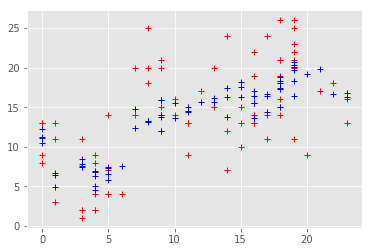

In [12]:
print('mean_absolute_error =', mean_absolute_error(test_y, predicted),'\n')
plt.plot(test_X['target_hour'], test_y, 'r+')
plt.plot(test_X['target_hour'], predicted, 'b+')
plt.show()

### Including cross-validation in train set

mean_absolute_error = 3.74924565761 



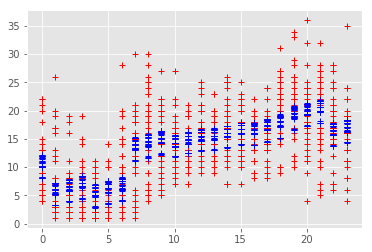

In [13]:
lr = LinearRegression(n_jobs=-1)
lr.fit(X, y)
p = lr.predict(X)
print('mean_absolute_error =', mean_absolute_error(test_y, predicted),'\n')
plt.plot(X['target_hour'], y, 'r+')
plt.plot(X['target_hour'], p, 'b+')
plt.show()

### Final Prediction

In [14]:
predict_X = test_data.drop(columns='target_trips')
predicted_y = lr.predict(predict_X)
print(train_X.shape)
print('target_hour ------>', 'predicted')
for i in range(0, len(test_data)):
    print(test_data.iloc[i]['target_hour'],'------>', predicted_y[i])

(648, 19)
target_hour ------> predicted
0.0 ------> 11.8767943599
1.0 ------> 7.1732927609
2.0 ------> 7.77822056218
3.0 ------> 8.36546854101
4.0 ------> 6.89878183638
5.0 ------> 7.62746839481
6.0 ------> 8.07327779403
7.0 ------> 15.2621843089
8.0 ------> 15.6195945958
9.0 ------> 16.2952416869
